# 실습7: Darknet을 이용하여 YOLOv3를 빌드하기

# 1. Darknet를 clone하기

In [1]:
# darknet repository에서 clone하기
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15502, done.
remote: Total 15502 (delta 0), reused 0 (delta 0), pack-reused 15502
Receiving objects: 100% (15502/15502), 14.17 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (10405/10405), done.


darknet clone하기


In [26]:
# GPU와 OPENCV의 사용이 가능하도록 makefile을 수정하기
%cd darknet
!sed -i 's/OPENCV=0/OPENCN=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [27]:
# CUDA 버전 확인하기
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [28]:
# make를 이용하여 darknet를 build
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/http_stream.cpp -o obj/http_stream.o
./src/http_stream.cpp: In member function ‘bool JSON_sender::write(const char*)’:
./src/http_stream.cpp:253:21: warning: unused variable ‘n’ [-Wunused-variable]
                 int n = _write(client, outputbuf, outlen);
                     ^
./src/http_stream.cpp: In function ‘void set_track_id(detection*, int, float, float, float, int, int, int)’:
./src/http_stream.cpp:867:27: warning: comparison between signed and unsigned integer expressions [-Wsign-c

# 2. 사전학습된 YOLOv3 파라미터를 다운로드
80개의 클래스를 갖는 coco데이터셋으로 학습되어있음, 사전 학습된 파라미터 다운로드하기

In [29]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2022-11-21 07:36:53--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  19.8MB/s    in 13s     

2022-11-21 07:37:07 (17.9 MB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]



In [30]:
# helper 함수들
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image, (3*width, 3*height), interpolation = cv2.INTER_CUBIC) # 영상을 3배로 키운다.

  fig = plt.gcf()
  fig.set_size_inches(18,10)
  plt.axis('off')
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [31]:
# google colab에서 파일을 업로드할 때 사용하는 함수 정의
def upload():
  from google.colab import files
  uploaded = files.upload()
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print('saved file', name)

# google colab에서 파일을 다운로드할 때 사용하는 함수를 정의
def download(path):
  from google.colab import files
  files.download(path)

# 3. Darknet과 YOLOv3를 실행시켜보기
지금까지 Darknet을 build 해봤고, 이제 YOLOv3 실행 가능해졌다.
Object Detector는 다음 코멘트로 실행시킬 수 있다.

 CUDA-version: 11020 (11020), cuDNN: 8.1.1, GPU count: 1  
 OpenCV isn't used - data augmentation will be slow 
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.59

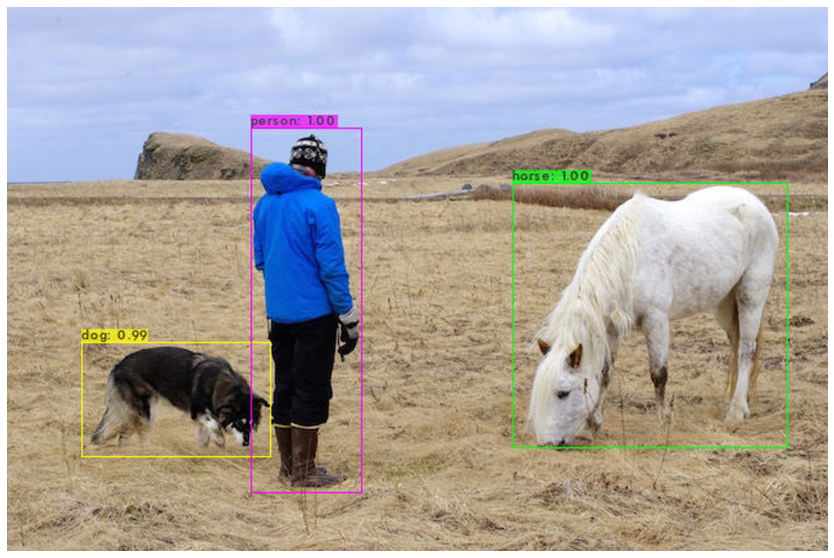

In [32]:
!./darknet detect /content/darknet/cfg/yolov3.cfg /content/darknet/yolov3.weights /content/darknet/data/person.jpg
imShow('predictions.jpg')

 CUDA-version: 11020 (11020), cuDNN: 8.1.1, GPU count: 1  
 OpenCV isn't used - data augmentation will be slow 
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.59

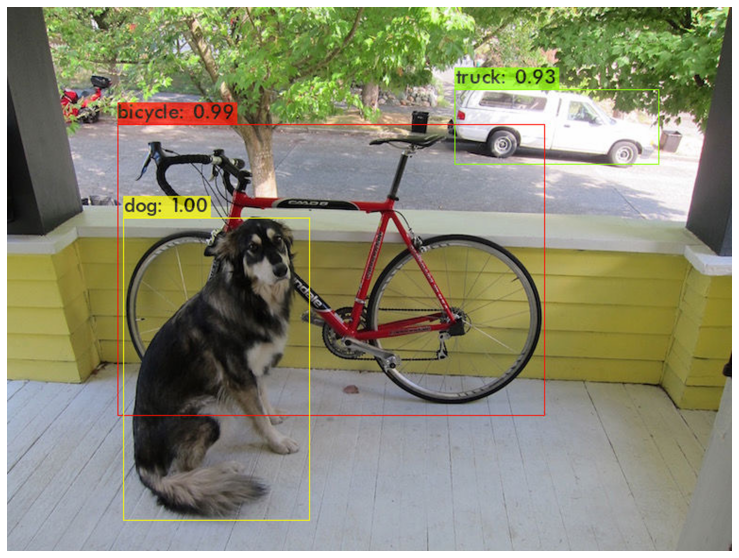

In [33]:
!./darknet detect /content/darknet/cfg/yolov3.cfg /content/darknet/yolov3.weights /content/darknet/data/dog.jpg
imShow('predictions.jpg')

# YOLOv5 자율주행 데이터 사물인식 실습

1. roboflow에서 제공하는 images 받아오기

In [34]:
# roboflow에서 제공하는 images 받아오기
!curl -L "https://public.roboflow.com/ds/0Q4TDaIgXT?key=v8qXdebOxZ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: export/labels/1478900099595044482_jpg.rf.Y48Kh5UJNyBAWFTA0w0y.txt  
 extracting: export/labels/1478900100165707353_jpg.rf.02dae94790fe0a5fd8145e6582060381.txt  
 extracting: export/labels/1478900100165707353_jpg.rf.mLJlW3Cf3VoVKjXY6jgh.txt  
 extracting: export/labels/1478900100737478288_jpg.rf.2bb35a1222e15394de7033687f69065c.txt  
 extracting: export/labels/1478900100737478288_jpg.rf.nbrgBfnnhHP0mwGGKfnW.txt  
 extracting: export/labels/1478900101309115339_jpg.rf.2508668be11307c87ff954cf21544d10.txt  
 extracting: export/labels/1478900101309115339_jpg.rf.OsDb7MLdxcxdujSvvLyR.txt  
 extracting: export/labels/1478900101879688623_jpg.rf.81c3be06336e0ae02178f47713d58e6f.txt  
 extracting: export/labels/1478900101879688623_jpg.rf.v2nxcO0TVyrQn6VcGa1D.txt  
 extracting: export/labels/1478900102451943901_jpg.rf.4kwTUlpUEj4Jc9ubppWJ.txt  
 extracting: export/labels/1478900102451943901_jpg.rf.bb6b07a82d52b84fdcc5593bc581128c.txt  
 extracting: 

2. yolo v5 clone 해오기

In [39]:
# yolov5 clone 해오기
%cd /content
!git clone https://github.com/ultralytics/yolov5.git

/content
fatal: destination path 'yolov5' already exists and is not an empty directory.


3. 필요한 라이브러리들을 install 해준다.

In [36]:
%cd /content/yolov5/
!pip install -r requirements.txt

/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 13.2 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 1.6 MB 65.1 MB/s 


4. data.yaml 파일을 확인해보자

In [40]:
%cat /content/dataset/data.yaml

cat: /content/dataset/data.yaml: No such file or directory


5. 앞서서 이미지가 잘 불어와 지는지, glob을 사용하여 확인해보자

In [41]:
%cd /
from glob import glob

img_list = glob('/content/dataset/export/images/*.jpg')
print(len(img_list))

/
0


In [ ]:
# 6. train, test data 나누기
from sklearn.model_selection import train_test_split

train_img_list, val_img_list = train_test_split(img_list, test_size=0.2, random_state=2000)

print(len(train_img_list), len(val_img_list))

In [ ]:
# 7. 두 img를 txt 파일로 저장해준다.
# 리스트로 되어있는 넘을 join을 사용하여 txt 파일로 저장해준다.

with open('/content/dataset/train.txt', 'w') as f: # write
  f.write('\n'.join(train_img_list) + '\n')

with open('/content/dataset/val.txt', 'w') as f: # write
  f.write('\n'.join(val_img_list) + '\n')

In [ ]:
# 8. yaml 파일에서 train, val의 위치를 7.에서 만든 txt로 변경해준다.
import yaml

with open('/content/dataset/data.yaml', 'r') as f: #read
  data = yaml.safe_load(f) # 문자열 -> 파이썬데이터로

print(data)

data['train'] = '/content/dataset/train.txt'
data['val'] = '/content/dataset/val.txt'

with open('/content/dataset/data.yaml', 'w') as f: #write
  yaml.dump(data, f) # 파이썬데이터 -> yaml 형태로

print(data)

In [ ]:
# 9. 학습 시키기
# 시간 상 epocs 를 10으로 설정하여 학습을 진행했다.
%cd /content/yolov5/

!python train.py --img 416 --batch 16 --epochs 10 --data /content/dataset/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name self_driving_car_yolov5_result

## 결과

In [ ]:
# 1. 텐서보드로 결과 확인하기
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs/

In [ ]:
# 2. 나누어 둔 테스트 데이터로 결과 확인하기
# 아래 코드에선 나누어둔 val_img_list 중 5번째 이미지로 테스트 해본 결과이다.

from IPython.display import Image
import os

val_img_path = val_img_list[5]

!python detect.py --weights /content/yolov5/runs/train/self_driving_car_yolov5_result2/weights/best.pt --img 416 --conf 0.5 --source "{val_img_path}"

Image(os.path.join('/content/yolov5/inference/output', os.path.basename(val_img_path)))